In [1]:
!pip -q install librosa soundfile umap-learn

In [2]:
import os, random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

import librosa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import kagglehub
kagglehub.dataset_download("thisisjibon/banglabeats3sec")

100%|██████████| 3.82G/3.82G [00:39<00:00, 104MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/thisisjibon/banglabeats3sec/versions/1'

In [5]:
MANIFEST = "/content/drive/MyDrive/hybrid_dataset/hybrid_en_bn_3sec_30000_manifest.csv"

OUT_DIR = Path("/content/drive/MyDrive/medium_task_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

CACHE_DIR = Path("/content/drive/MyDrive/medium_task_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

print("OUT_DIR:", OUT_DIR)
print("CACHE_DIR:", CACHE_DIR)

OUT_DIR: /content/drive/MyDrive/medium_task_outputs
CACHE_DIR: /content/drive/MyDrive/medium_task_cache


In [6]:
df = pd.read_csv(MANIFEST)
print("Loaded:", df.shape)
print(df["language"].value_counts())

possible_lyric_cols = ["lyrics", "lyrics_text", "clip_lyrics", "asr_text", "lyric_text"]
LYR_COL = next((c for c in possible_lyric_cols if c in df.columns), None)

print("Detected lyric column:", LYR_COL)
df.head()

Loaded: (30000, 17)
language
english    15000
bengali    15000
Name: count, dtype: int64
Detected lyric column: lyrics_text


,song_id,clip_idx,abs_t0,abs_t1,rel_t0,rel_t1,clip_path,language,source_dataset,genres,lyrics_text,lyrics_len,clip_uid,language_id,has_lyrics,word_count,char_count
0,8247bc1d70ba4c4a9a9ae8cad93480ff,6,48.0,51.0,18.0,21.0,/content/drive/MyDrive/dali_en_clips_3s/c3d765...,english,dali,Pop,i've searched for the perfect love all my life,46,dali::8247bc1d70ba4c4a9a9ae8cad93480ff::6,0,True,9,46
1,Adhunik__000167,2,6.0,9.0,6.0,9.0,/kaggle/input/banglabeats3sec/wavs3sec/Adhunik...,bengali,banglabeats,Adhunik,NaN,0,banglabeats::Adhunik__000167::2,1,False,0,0
2,Rock__000184,1,3.0,6.0,3.0,6.0,/kaggle/input/banglabeats3sec/wavs3sec/Rock/18...,bengali,banglabeats,Rock,NaN,0,banglabeats::Rock__000184::1,1,False,0,0
3,Folk__000014,2,6.0,9.0,6.0,9.0,/kaggle/input/banglabeats3sec/wavs3sec/Folk/14...,bengali,banglabeats,Folk,NaN,0,banglabeats::Folk__000014::2,1,False,0,0
4,743189d4a1cc4dadbb7312d3b17defaf,3,39.0,42.0,9.0,12.0,/content/drive/MyDrive/dali_en_clips_3s/c3d765...,english,dali,"Jazz,Pop",and children listen to hear sleigh bells in th...,53,dali::743189d4a1cc4dadbb7312d3b17defaf::3,0,True,10,53


In [8]:
y_lang = np.where(df["language"].values == "english", 0, 1).astype(np.int32)

In [7]:
def logmel_64x128(path, sr=22050, n_mels=64, n_fft=1024, hop=256, target_frames=128):
    y, _ = librosa.load(path, sr=sr, mono=True)

    # loudness normalization (simple)
    peak = np.max(np.abs(y)) + 1e-8
    y = y / peak

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop, power=2.0)
    S_db = librosa.power_to_db(S, ref=np.max)  # typically [-80, 0]

    # normalize to [0,1] using a fixed floor
    S_db = np.clip(S_db, -80.0, 0.0)
    S01 = (S_db + 80.0) / 80.0  # [-80..0] -> [0..1]

    # pad/truncate time frames to target_frames
    T = S01.shape[1]
    if T < target_frames:
        pad = target_frames - T
        S01 = np.pad(S01, ((0,0),(0,pad)), mode="constant")
    else:
        S01 = S01[:, :target_frames]

    return S01.astype(np.float32)  # (64,128)

In [8]:
X_NPY = CACHE_DIR / f"X_logmel64x128_{len(df)}.npy"
META_CSV = CACHE_DIR / f"meta_{len(df)}.csv"

if X_NPY.exists() and META_CSV.exists():
    X_mel = np.load(X_NPY)  # (N,64,128)
    meta = pd.read_csv(META_CSV)
    print("Loaded cached:", X_mel.shape, meta.shape)
else:
    X_list, meta_rows = [], []
    bad = 0
    for _, r in tqdm(df.iterrows(), total=len(df), desc="Log-mel extraction"):
        p = str(r["clip_path"])
        try:
            X_list.append(logmel_64x128(p))
            meta_rows.append({
                "clip_path": p,
                "language": r["language"],
                "genres": r.get("genres",""),
                "source_dataset": r.get("source_dataset",""),
                "lyrics": (r[LYR_COL] if (LYR_COL is not None and pd.notna(r[LYR_COL])) else "")
            })
        except Exception:
            bad += 1

    X_mel = np.stack(X_list, axis=0)
    meta = pd.DataFrame(meta_rows)

    np.save(X_NPY, X_mel)
    meta.to_csv(META_CSV, index=False)
    print("Saved cache:", X_mel.shape, meta.shape, "bad:", bad)

X_mel.shape

Log-mel extraction:   0%|          | 0/30000 [00:00<?, ?it/s]

Saved cache: (30000, 64, 128) (30000, 5) bad: 0


(30000, 64, 128)

In [10]:
X_img = X_mel[..., None]  # (N,64,128,1)
print("X_img:", X_img.shape)

X_img: (30000, 64, 128, 1)


In [11]:
def build_conv_vae(input_shape=(64,128,1), latent_dim=16, beta=1.0, lr=1e-3):
    # Encoder
    enc_in = keras.Input(shape=input_shape, name="x_in")
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(enc_in)   # 32x64
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)       # 16x32
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)      # 8x16
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_logvar = layers.Dense(latent_dim, name="z_logvar")(x)

    def sampling(args):
        m, lv = args
        eps = tf.random.normal(shape=tf.shape(m))
        return m + tf.exp(0.5 * lv) * eps

    z = layers.Lambda(sampling, name="z")([z_mean, z_logvar])
    encoder = keras.Model(enc_in, [z_mean, z_logvar, z], name="encoder")

    # Decoder
    dec_in = keras.Input(shape=(latent_dim,), name="z_in")
    x = layers.Dense(8*16*128, activation="relu")(dec_in)
    x = layers.Reshape((8,16,128))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)  # 16x32
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)   # 32x64
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)   # 64x128
    dec_out = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)               # 64x128x1
    decoder = keras.Model(dec_in, dec_out, name="decoder")

    class VAE(keras.Model):
        def __init__(self, encoder, decoder, beta=1.0):
            super().__init__()
            self.encoder = encoder
            self.decoder = decoder
            self.beta = beta
            self.total_loss_tracker = keras.metrics.Mean(name="loss")
            self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

        def train_step(self, data):
            x = data[0] if isinstance(data, tuple) else data
            with tf.GradientTape() as tape:
                z_mean, z_logvar, z = self.encoder(x, training=True)
                x_hat = self.decoder(z, training=True)

                recon = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
                kl = -0.5 * tf.reduce_mean(tf.reduce_sum(
                    1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1
                ))
                loss = recon + self.beta * kl

            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

            self.total_loss_tracker.update_state(loss)
            self.recon_loss_tracker.update_state(recon)
            self.kl_loss_tracker.update_state(kl)
            return {m.name: m.result() for m in self.metrics}

    vae = VAE(encoder, decoder, beta=beta)
    vae.compile(optimizer=keras.optimizers.Adam(lr))
    return vae, encoder, decoder

In [12]:
latent_dim = 16
beta = 1.0
EPOCHS = 30
BATCH = 128

tf.keras.backend.clear_session()
tf.random.set_seed(SEED)

vae, enc, dec = build_conv_vae(input_shape=X_img.shape[1:], latent_dim=latent_dim, beta=beta, lr=1e-3)

ds = tf.data.Dataset.from_tensor_slices(X_img).shuffle(len(X_img), seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)

hist = vae.fit(ds, epochs=EPOCHS, verbose=1)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - kl_loss: 1.7001 - loss: 138.2851 - recon_loss: 136.5850
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - kl_loss: 6.4254 - loss: 71.8356 - recon_loss: 65.4102
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - kl_loss: 8.3935 - loss: 60.3393 - recon_loss: 51.9458
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - kl_loss: 8.8389 - loss: 55.0370 - recon_loss: 46.1982
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - kl_loss: 8.7356 - loss: 51.8675 - recon_loss: 43.1319
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - kl_loss: 8.6133 - loss: 51.0040 - recon_loss: 42.3907
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - kl_loss: 8.5696 - loss: 49.9891 - recon_loss: 41.4195
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - kl_loss: 8.5107 - loss: 49.5794 - recon_loss: 41.0688
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - kl_loss: 8.5001 - loss: 49.7317 - recon_loss: 41.2317
Epoch 10/30
235/

In [13]:
z_mean, _, _ = enc.predict(X_img, batch_size=256, verbose=0)
print("z_mean:", z_mean.shape)

np.save(OUT_DIR / "z_mean_audio.npy", z_mean)

z_mean: (30000, 16)


In [14]:
texts = meta["lyrics"].fillna("").astype(str).values

# char n-grams work nicely across English + Bengali scripts
tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    max_features=20000,
    min_df=2
)
X_tfidf = tfidf.fit_transform(texts)

svd_dim = 128
svd = TruncatedSVD(n_components=svd_dim, random_state=SEED)
X_lyr = svd.fit_transform(X_tfidf).astype(np.float32)

print("X_lyr:", X_lyr.shape)

np.save(OUT_DIR / "lyrics_svd.npy", X_lyr)

X_lyr: (30000, 128)


In [15]:
# Scale each block then concatenate (important for fair fusion)
Za = StandardScaler().fit_transform(z_mean)
Zt = StandardScaler().fit_transform(X_lyr)

Z_fused = np.concatenate([Za, Zt], axis=1).astype(np.float32)
print("Z_fused:", Z_fused.shape)

np.save(OUT_DIR / "Z_fused.npy", Z_fused)

Z_fused: (30000, 144)


In [16]:
def eval_clustering(Z, labels, y_true):
    # handle DBSCAN noise
    mask = labels != -1
    Zm = Z[mask]
    lm = labels[mask]
    ym = y_true[mask]

    out = {"n_points_used": int(mask.sum()), "n_noise": int((~mask).sum())}

    # must have at least 2 clusters
    n_clusters = len(set(lm))
    out["n_clusters"] = int(n_clusters)

    if n_clusters < 2 or len(lm) < 10:
        out.update({"silhouette": np.nan, "davies_bouldin": np.nan, "ari": np.nan})
        return out

    out["silhouette"] = float(silhouette_score(Zm, lm))
    out["davies_bouldin"] = float(davies_bouldin_score(Zm, lm))  # lower is better
    out["ari"] = float(adjusted_rand_score(ym, lm))
    return out


def run_all_clusterers(Z, y_true, k=2):
    rows = []

    # KMeans
    km = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
    lab = km.fit_predict(Z)
    rows.append({"algo":"kmeans", **eval_clustering(Z, lab, y_true)})

    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    lab = agg.fit_predict(Z)
    rows.append({"algo":"agglomerative_ward", **eval_clustering(Z, lab, y_true)})

    # DBSCAN with automatic eps heuristic from kNN distances
    nn = NearestNeighbors(n_neighbors=10).fit(Z)
    dists, _ = nn.kneighbors(Z)
    kdist = np.sort(dists[:, -1])
    eps = float(np.quantile(kdist, 0.95))  # heuristic
    db = DBSCAN(eps=eps, min_samples=10)
    lab = db.fit_predict(Z)
    rows.append({"algo":f"dbscan_eps{eps:.3f}", **eval_clustering(Z, lab, y_true)})

    return pd.DataFrame(rows)

# Compare 3 representations: audio only, lyrics only, fused
res_audio = run_all_clusterers(Za, y_lang, k=2)
res_audio.insert(0, "repr", "audio_zmean")

res_lyr = run_all_clusterers(Zt, y_lang, k=2)
res_lyr.insert(0, "repr", "lyrics_svd")

res_fused = run_all_clusterers(Z_fused, y_lang, k=2)
res_fused.insert(0, "repr", "fused_audio+lyrics")

df_metrics = pd.concat([res_audio, res_lyr, res_fused], ignore_index=True)
df_metrics

,repr,algo,n_points_used,n_noise,n_clusters,silhouette,davies_bouldin,ari
0,audio_zmean,kmeans,30000,0,2,0.151420,3.172359,0.525224
1,audio_zmean,agglomerative_ward,30000,0,2,0.120845,3.551629,0.866384
2,audio_zmean,dbscan_eps3.844,29379,621,1,NaN,NaN,NaN
3,lyrics_svd,kmeans,30000,0,2,0.311134,9.949290,0.233141
4,lyrics_svd,agglomerative_ward,30000,0,2,0.473908,0.374238,0.000014
5,lyrics_svd,dbscan_eps16.316,29750,250,7,0.442732,0.349743,-0.000112
6,fused_audio+lyrics,kmeans,30000,0,2,0.213661,6.487995,0.010823
7,fused_audio+lyrics,agglomerative_ward,30000,0,2,0.110671,7.491061,0.860685
8,fused_audio+lyrics,dbscan_eps16.815,29759,241,7,0.377178,0.577790,-0.000100


In [17]:
metrics_path = OUT_DIR / "medium_task_clustering_metrics.csv"
df_metrics.to_csv(metrics_path, index=False)
print("Saved ->", metrics_path)

Saved -> /content/drive/MyDrive/medium_task_outputs/medium_task_clustering_metrics.csv


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


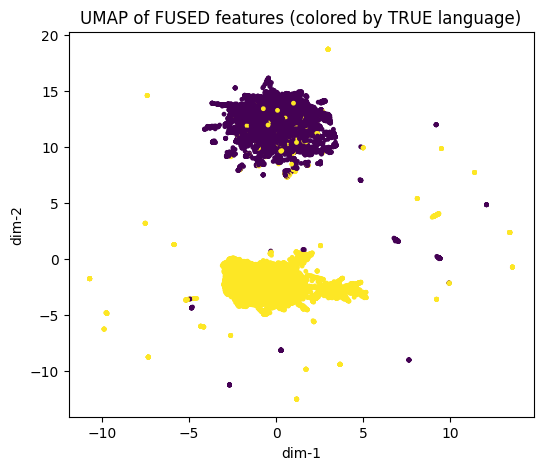

In [18]:
import umap

reducer = umap.UMAP(n_components=2, random_state=SEED)
Z2 = reducer.fit_transform(Z_fused)

plt.figure(figsize=(6,5))
plt.scatter(Z2[:,0], Z2[:,1], c=y_lang, s=6)
plt.title("UMAP of FUSED features (colored by TRUE language)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.show()

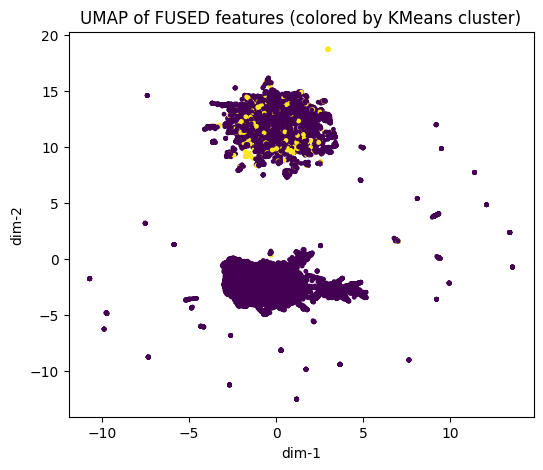

In [19]:
km = KMeans(n_clusters=2, random_state=SEED, n_init="auto")
labels = km.fit_predict(Z_fused)

plt.figure(figsize=(6,5))
plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=6)
plt.title("UMAP of FUSED features (colored by KMeans cluster)")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.show()

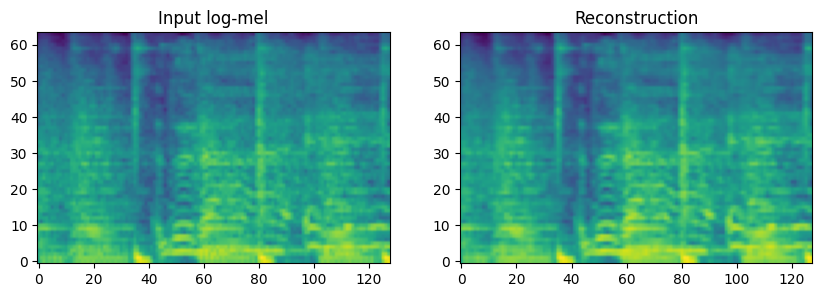

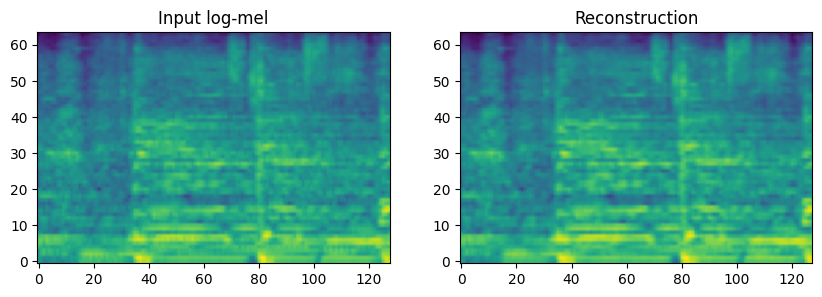

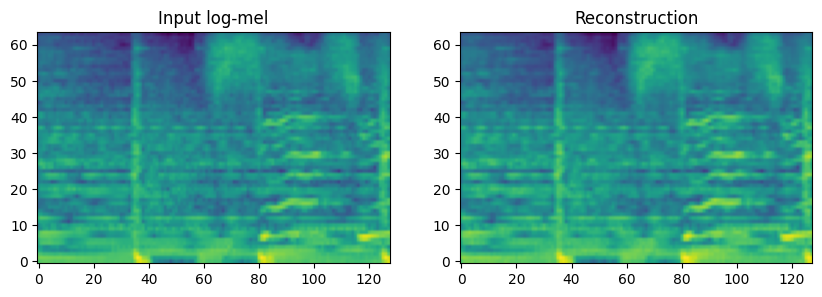

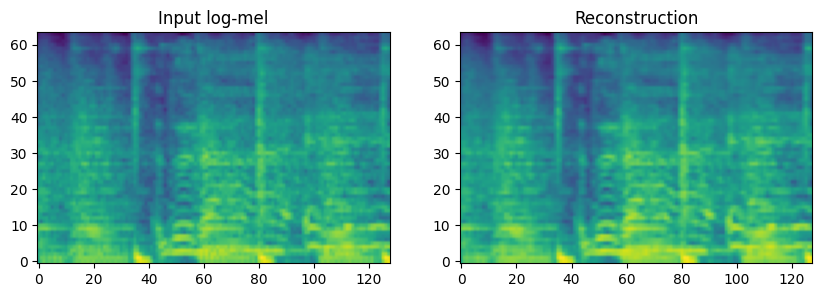

In [20]:
# pick a few random examples
idx = np.random.RandomState(SEED).choice(len(X_img), size=4, replace=False)
X_in = X_img[idx]
Z_mu, _, _ = enc.predict(X_in, verbose=0)
X_hat = dec.predict(Z_mu, verbose=0)

for i in range(len(idx)):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.imshow(X_in[i,:,:,0], aspect="auto", origin="lower")
    plt.title("Input log-mel")
    plt.subplot(1,2,2)
    plt.imshow(X_hat[i,:,:,0], aspect="auto", origin="lower")
    plt.title("Reconstruction")
    plt.show()